In [3]:
# 이미지 제네레이터를 사용하여 이미지 그려보기

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

In [4]:
import matplotlib.pyplot as plt
import numpy as np

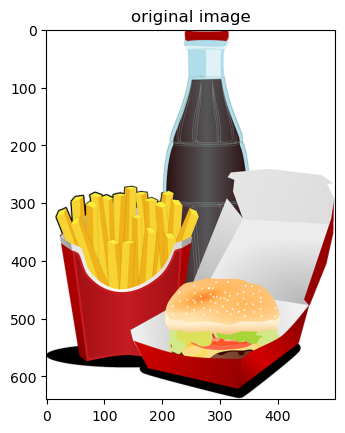

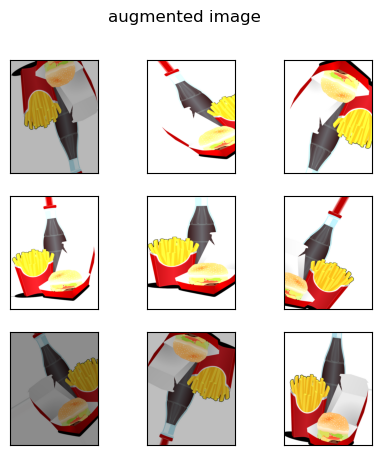

In [5]:
# 이미지 제네레이터를 선언합니다.

train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True,
                                   shear_range = 0.5,
                                   brightness_range = [0.5, 1.5],
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 30,
                                   fill_mode = 'nearest'
                                  )

# 햄버거 사진을 불러옵니다.
hamburger = img_to_array(load_img('C:/Work/1stDL/Roadbook_DeepLearning-master/TF_2.5v/code/ch5/data/hamburger.png')
                         ).astype(np.uint8)
plt.figure(); plt.title('original image'); plt.imshow(hamburger)

# 제네레이터를 사용해서 이미지를 변환합니다.
hamburger = hamburger.reshape((1, ) + hamburger.shape)
train_generator = train_datagen.flow(hamburger, batch_size = 1)

fig = plt.figure(figsize = (5, 5))
fig.suptitle('augmented image')

for i in range(9):
    data = next(train_generator)    # 제네레이터에게서 이미지를 받아옵니다.
    image = data[0]
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(image, dtype = np.uint8), cmap = 'gray')

plt.show()

In [6]:
# 데이터 증식 사용하여 학습하기

from tensorflow.keras.datasets import cifar10
import numpy as np
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

norm_layer = tf.keras.layers.Normalization(axis = -1, dtype = 'float32')
norm_layer.adapt(x_train)

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size = 0.3, random_state = 777)

# sparse_categorical_crossentropy를 사용하기 위해선 (batch_size, ) 형태를 가져야합니다.
# 따라서 np.squeeze를 사용해서 마지막 차원을 없애줍니다.
# y_train의 경우 (35000, 1) -> (35000, )이 됩니다.
y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)

print('data ready~')

data ready~


In [7]:
# 이미지 제네레이터를 사용하여 모델 학습하기

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 30,
                                   fill_mode = 'nearest'
                                  )

# 검증 데이터셋에는 변환을 사용하지 않습니다.
val_datagen = ImageDataGenerator()

batch_size = 32

train_generator = train_datagen.flow(x_train, y_train,
                                    batch_size = batch_size)
val_generator = val_datagen.flow(x_val, y_val,
                                batch_size = batch_size)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Activation, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape = (32, 32, 3)),
    norm_layer
])

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer = Adam(1e-4),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])

def get_step(train_len, batch_size):
    if(train_len % batch_size > 0):
        return train_len // batch_size + 1
    else:
        return train_len // batch_size

In [9]:
history = model.fit(train_generator, epochs = 100,
                    steps_per_epoch = get_step(len(x_train), batch_size),
                    validation_data = val_generator,
                    validation_steps = get_step(len(x_val), batch_size))

C:\Users\human\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 597s 306ms/step - acc: 0.3474 - loss: 1.8312 - val_acc: 0.5050 - val_loss: 1.3615
Epoch 2/100


c:\Dev\Anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 307s 280ms/step - acc: 0.4998 - loss: 1.3943 - val_acc: 0.5629 - val_loss: 1.2186
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 222s 202ms/step - acc: 0.5420 - loss: 1.2800 - val_acc: 0.5963 - val_loss: 1.1493
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 263s 240ms/step - acc: 0.5745 - loss: 1.1863 - val_acc: 0.5944 - val_loss: 1.1448
Epoch 8/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 264s 241ms/step - acc: 0.6032 - loss: 1.1294 - val_acc: 0.6421 - val_loss: 1.0107
Epoch 10/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/100
1094/1094 ━━━━━━━━━━━━━━━━━━

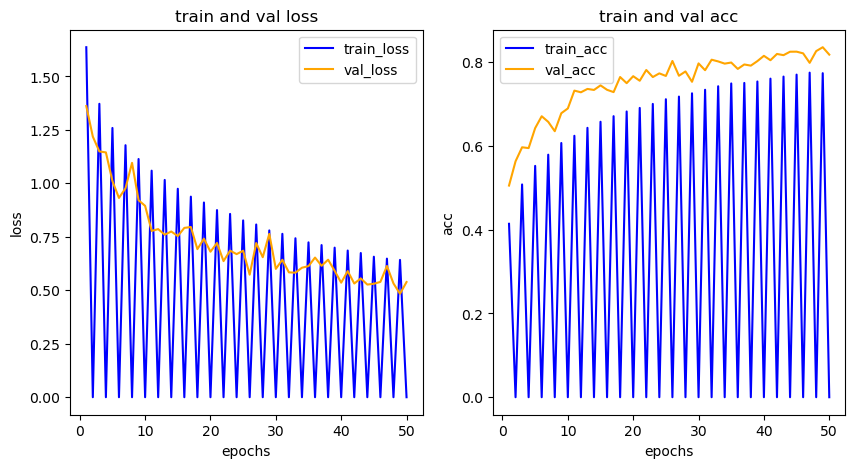

In [16]:
# 학습 과정 그리기

import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, min(len(loss), len(val_loss)) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss[:len(epochs)], color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss[:len(epochs)], color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc[:len(epochs)], color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc[:len(epochs)], color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [17]:
history = model.fit(train_generator, epochs = 5,
                    steps_per_epoch = get_step(len(x_train), batch_size),
                    validation_data = val_generator,
                    validation_steps = get_step(len(x_val), batch_size))

Epoch 1/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 205s 187ms/step - acc: 0.8444 - loss: 0.4434 - val_acc: 0.7998 - val_loss: 0.6208
Epoch 2/5


c:\Dev\Anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 201s 184ms/step - acc: 0.8442 - loss: 0.4453 - val_acc: 0.8291 - val_loss: 0.5052
Epoch 4/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 175s 159ms/step - acc: 0.8466 - loss: 0.4418 - val_acc: 0.8039 - val_loss: 0.5970


ValueError: x and y must have same first dimension, but have shapes (5,) and (3,)

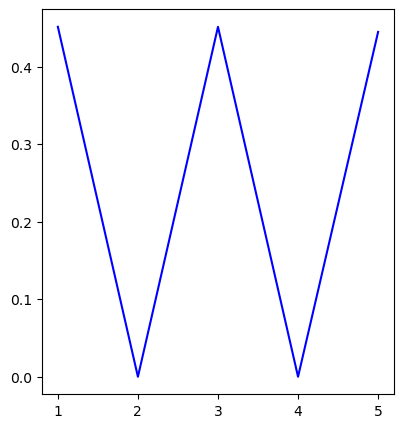

In [19]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()